In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr
from datetime import datetime
from sklearn.metrics import mean_squared_error 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#My stuff starts In[37]

In [10]:
plPrice = pd.read_csv('plPrice17-19.csv')
plPrice.drop(columns = ['Hong Kong 8:30','Hong Kong 14:00','New York 9:30'],inplace = True)
plPrice.rename(columns = {'London 09:00':'Price'},inplace= True)
plPrice.dropna(how='any',inplace = True)
plPrice.to_csv('plPrice17-20Updated.csv')
plPrice['Date'] = pd.to_datetime(plPrice['Date'])
plPrice=plPrice[plPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]
plPrice19=plPrice[plPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]

In [11]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]

simulatedFTSE = pd.read_csv('fullSimulatedFTSEPrice.csv')
simulatedFTSE.rename(columns = {'Unnamed: 0':'Date'},inplace = True)
simulatedFTSE['Date'] = pd.to_datetime(simulatedFTSE['Date'])


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)


In [12]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    for idx, quarter in enumerate(quarterNames):
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)

        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        #iterates over each stock in the FTSE that quarter
        for stock in FTSEStocksEachQuarter[quarter]:
            #adds tilt from aray to the company weight
            stockWeightsOpen[stock] = stockWeightsOpen[stock].add(tilt.loc[stock][0])
            stockWeightsClose[stock] = stockWeightsClose[stock].add(tilt.loc[stock][0])

        #if weight is <0 then set to 0
        stockWeightsOpen[stockWeightsOpen < 0] = 0
        stockWeightsClose[stockWeightsClose < 0] = 0

        #calculates effective market caps using new weight and old market caps 
        newMarketCapsOpen = stockWeightsOpen*stockMarketCapsEachQuarterOpen.values
        newMarketCapsClose = stockWeightsClose*stockMarketCapsEachQuarterClose.values

        #calculates new total market cap each day
        newTotalMarketCapsOpen = newMarketCapsOpen.sum(axis=1).to_frame()
        newTotalMarketCapsClose = newMarketCapsClose.sum(axis=1).to_frame()

        #calculates index divisor to make sure price stays continuous over the change in quarter
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.values[0][0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.values[0][0]/FTSEPriceQuarterly['Close'].values[-1]


        #calculates new tilted price using index divisor and tilted market caps

        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)


    
    return FTSEPrice3yr
   

In [13]:

FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)

def jackTilt(catTilts,tiltWeights):
    # Assigns the catTilts to each company and runs tiltFTSE.
    minePd,mineOth,autoRel,autoCar,defenceInd,finSec,jMat,noInt=catTilts
    tiltWeights['Weights'] = [
    minePd	#AAL
    ,noInt	#ABF
    ,noInt	#ADM
    ,noInt	#AHT
    ,mineOth #ANTO
    ,autoCar	#AUTO
    ,noInt	#AV.
    ,noInt	#AVV
    ,noInt	#AZN
    ,defenceInd	#BA.
    ,defenceInd	#BAB
    ,noInt	#BARC
    ,noInt	#BATS
    ,noInt	#BDEV
    ,mineOth#BHP
    ,noInt	#BKG
    ,noInt	#BLND
    ,autoRel #BNZL
    ,noInt	#BP
    ,noInt	#BRBY
    ,noInt	#BT-A
    ,noInt	#CCH
    ,noInt	#CCL
    ,noInt	#CNA
    ,noInt	#CPG
    ,noInt	#CRDA
    ,noInt	#CRH
    ,noInt	#CTEC
    ,noInt	#DCC
    ,noInt	#DGE
    ,noInt	#DLG
    ,mineOth #EVR
    ,noInt	#EXPN
    ,autoRel #EZJ
    ,noInt	#FERG
    ,noInt	#FLTR
    ,mineOth #FRES
    ,noInt	#GFS
    ,mineOth #GLEN
    ,noInt	#GSK
    ,noInt	#GVC
    ,noInt	#HIK
    ,finSec #HL.
    ,noInt	#HLMA
    ,noInt	#HMSO
    ,finSec #HSBA
    ,noInt	#HSX
    ,noInt	#IAG
    ,noInt	#IHG
    ,finSec #III
    ,noInt	#IMB
    ,noInt	#INF
    ,noInt	#ITRK
    ,noInt	#ITV
    ,noInt	#JD.
    ,noInt	#JE.
    ,jMat	#JMAT
    ,noInt	#KGF
    ,noInt	#LAND
    ,finSec	#LGEN
    ,finSec	#LLOY
    ,finSec	#LSE
    ,noInt	#MCRO
    ,noInt	#MDC
    ,defenceInd	#MGGT
    ,noInt	#MKS
    ,noInt	#MNDI
    ,finSec #MNG
    ,finSec #MRO
    ,noInt	#MRW
    ,noInt	#NG.
    ,noInt	#NMC
    ,noInt	#NXT
    ,autoRel #OCDO
    ,finSec #PFG
    ,noInt	#PHNX
    ,minePd	#POLY
    ,finSec #PRU
    ,noInt	#PSN
    ,noInt	#PSON
    ,noInt	#RB.
    ,finSec #RBS
    ,noInt	#RDSA
    ,noInt	#RDSB
    ,noInt	#REL
    ,mineOth #RIO
    ,defenceInd	#RMG
    ,noInt	#RMV
    ,defenceInd	#RR.
    ,noInt	#RSA
    ,noInt	#RTO
    ,noInt	#SBRY
    ,finSec #SDR
    ,noInt	#SGE
    ,noInt	#SGRO
    ,noInt	#SKG
    ,finSec #SLA
    ,noInt	#SMDS
    ,mineOth #SMIN
    ,finSec #SMT
    ,noInt	#SN.
    ,noInt	#SPX
    ,noInt	#SSE
    ,finSec #STAN
    ,finSec #STJ
    ,noInt	#SVT
    ,noInt	#TSCO
    ,noInt	#TUI
    ,noInt	#TW.
    ,noInt	#ULVR
    ,noInt	#UU.
    ,noInt	#VOD
    ,noInt	#WG.
    ,noInt	#WPP
    ,noInt	#WTB
    ]
    return tiltFTSE(tiltWeights)


In [14]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)

#My Traditional Method Values.
minePd = 2
mineOth = 1.5
autoRel = -0.5
autoCar = -2
defenceInd = -1
finSec =  0.5
jMat = 1
noInt = 0
catTilts = [minePd,mineOth,autoRel,autoCar
            ,defenceInd,finSec,jMat,noInt]
jackTiltNos = [2,1.5,-0.5,-2,-1,0.5,1,0]
tiltedFTSE = jackTilt(catTilts,tiltWeights)


In [49]:
def findBestTiltCat(catTilt,tiltWeights):
    #Finds the best tilt for the first non-zero item in catTilt.
    currentVal = 0 
    counter=-1
    while currentVal == 0:
        currentVal = catTilt[counter+1]
        counter+=1
    bestI = 0
    bestCorr = 0
    for i in np.linspace(-2,2,41):
        catTilt[counter]=i
        tiltedFTSE = jackTilt(catTilt,tiltWeights)

        #Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
        tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
        #Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
        #

        #find correlation between tilted FTSE and palladium price
        correlationTiltedFTSE = spearmanr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
        #Note: currently set to find strongest absolute correlation.
        if abs(correlationTiltedFTSE[0])<bestCorr:
            bestI=i
            bestCorr = abs(correlationTiltedFTSE[0])
    print(round(bestI,1))
    return round(bestI,1)

In [50]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
#Find the best tilt for each category
#Warning: Takes quite a while... Don't run unless trying different findBestTiltCat approach
bestMinePd = findBestTiltCat([1,0,0,0,0,0,0,0],tiltWeights)
bestmineOth = findBestTiltCat([0,1,0,0,0,0,0,0],tiltWeights)
bestautoRel = findBestTiltCat([0,0,1,0,0,0,0,0],tiltWeights)
bestautoCar = findBestTiltCat([0,0,0,1,0,0,0,0],tiltWeights)
bestdefenceInd= findBestTiltCat([0,0,0,0,1,0,0,0],tiltWeights)
bestfinSec =  findBestTiltCat([0,0,0,0,0,1,0,0],tiltWeights)
bestjMat = findBestTiltCat([0,0,0,0,0,0,1,0],tiltWeights)
bestnoInt = findBestTiltCat([0,0,0,0,0,0,0,1],tiltWeights)
print([bestMinePd,bestmineOth,bestautoRel,bestautoCar,bestdefenceInd,bestfinSec,bestjMat,bestnoInt])

0
0
0
0
0
0
0
0
[0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
#Saved results of prior cell.

#Magnitude of Correlation
firstAttempt = [-2.0, -2.0, 2.0, -2.0, 0.0, 0.0, -2.0, -0.1]
#Only Positve
secondAttempt = [0, 0, 0, 0, 0, 0, 0, 2.0] 
#Only negative
thirdAttempt = [-2.0, -2.0, 2.0, -2.0, 0.0, 0.0, -2.0, -0.1]
#Spearman Magnitude
fourthAttempt = [0, 0, 0, 0, 0, 0, 0, 0]

tiltedFTSE = jackTilt(secondAttempt,tiltWeights)
#End of bit I did...

c:\python36-32\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


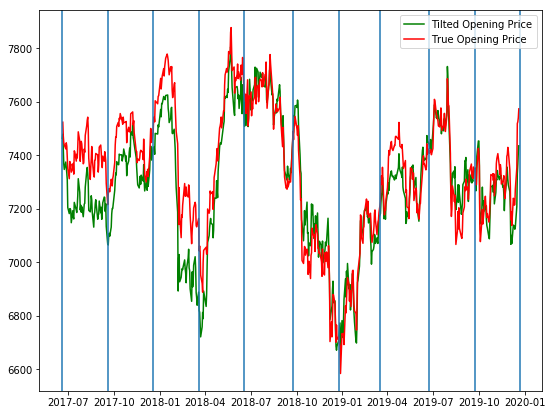

In [22]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(tiltedFTSE.index.values,tiltedFTSE['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)
f.show()

Pearson CC between tilted FTSE and Pl price:  0.26469313598893063
Pearson CC between real FTSE price and Pl price:  0.35506803242085316
Pearson CC between simulated (untilted) FTSE and Pl price:  0.19712841527467906

Tilt MSE 32599081.99304631 
Simulated FTSE MSE 33226522.349319074 
Percentage improvement 1.888372035075836 %

Percentage Change correlation - tilted and pl 0.057960858235296224
Percentage Change correlation - untilted and pl 0.11231818797891009


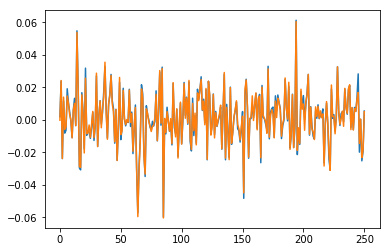

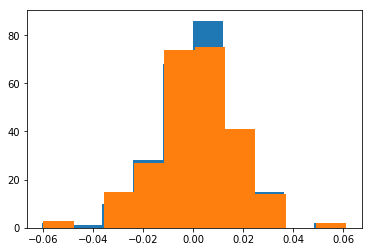

In [23]:
#Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
simulatedFTSE2019=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()) & (simulatedFTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date())]
FTSE2019=FTSE[(FTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()) & (FTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date())]

#Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
#

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE[0])

#correlation between real FTSE and pl price
correlationFTSE = pearsonr(FTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between real FTSE price and Pl price: ',correlationFTSE[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE = pearsonr(simulatedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between simulated (untilted) FTSE and Pl price: ',correlationSimFTSE[0])

#will only use simulated untilted FTSE price from now on

#Find mean squared error between pl price and tilted/simulated FTSE
mseTilt = mean_squared_error(plPrice19['Price'].values,tiltedFTSE2019['Open'].values)
mseSimu = mean_squared_error(plPrice19['Price'].values,simulatedFTSE2019['Open'].values)
print('\nTilt MSE',mseTilt,'\nSimulated FTSE MSE' ,mseSimu, '\nPercentage improvement',(1-mseTilt/mseSimu)*100,'%' )

#find daily percentage changes for tilted FTSE , untilted simulated and pl price
percentageChangeTilted = ((tiltedFTSE2019['Open'].shift(-1) / tiltedFTSE2019['Open']) - 1).reset_index()
percentageChangeSimuFTSE = ((simulatedFTSE2019['Open'].shift(-1) / simulatedFTSE2019['Open']) - 1).reset_index()
percentageChangePl = ((plPrice19['Price'].shift(-1) /  plPrice19['Price']) - 1).reset_index()

#find the difference in daily percentage change between pl price and both Tilted FTSE and simulated untilted FTSE
PCDiffTilt = (percentageChangePl['Price'][:-1] - percentageChangeTilted['Open'][:-1])
PCDiffSim = (percentageChangePl['Price'][:-1] - percentageChangeSimuFTSE['Open'][:-1])

#find corrleation between daily percentage changes for pl price and tilted FTSE
print('\nPercentage Change correlation - tilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeTilted['Open'][:-1])[0])
print('Percentage Change correlation - untilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeSimuFTSE['Open'][:-1])[0])

#plot of the daily percentage change difference between [pl and tilted] and [pl and untilted] 
plt.figure(1)
plt.plot(PCDiffTilt.index.values, PCDiffTilt)
plt.plot(PCDiffSim.index.values, PCDiffSim)

#histogram of daily percentage change difference
plt.figure(2)
plt.hist(PCDiffSim)
plt.hist(PCDiffTilt)
plt.show()


# moving average stuff
#movingAveragePCPl = percentageChangePl.rolling(5, min_periods=1).mean()
#movingAveragePCTilt = percentageChangeTilted.rolling(5, min_periods=1).mean()
#print(pearsonr(simulatedFTSE2019['Open'].values,FTSE2019['Open'].values))
#print('MA correlation', pearsonr(movingAveragePCPl,movingAveragePCTilt))

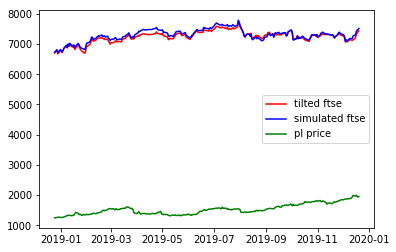

In [24]:
#plot of absolute tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].values, 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].values, 'g-' ,label = 'pl price')
plt.legend()
plt.show()

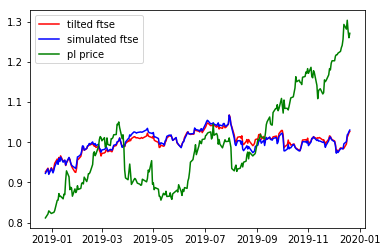

In [25]:
#plot of normalised tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].divide(tiltedFTSE2019['Open'].mean()).values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].divide(simulatedFTSE2019['Open'].mean()), 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].divide(plPrice19['Price'].mean()), 'g-' ,label = 'pl price')
plt.legend()
plt.show()

In [26]:
#Get only 2018 FTSE values for tilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
simulatedFTSE2018=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (simulatedFTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
FTSE2018=FTSE[(FTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (FTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y'))]

#get pl price for 2018
plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]

#--------using FTSE tilted using weights trained on 2019---------

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE2018 = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE2018[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE2018 = pearsonr(simulatedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between simulated (untilted) FTSE price and Pl price: ',correlationSimFTSE2018[0])

#correlation between real FTSE and pl price
correlationFTSE2018 = pearsonr(FTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between real FTSE and Pl price: ',correlationFTSE2018[0])




Pearson CC between tilted FTSE and Pl price:  -0.46333501605011257
Pearson CC between simulated (untilted) FTSE price and Pl price:  -0.5305275937035296
Pearson CC between real FTSE and Pl price:  -0.5472277825446668
